## Data augmentation
#### Author: Pinglei He, Kaiao Wen, Albache Jean, Augusto Oliveira, Yassine Oudghiri

## Creation of dedicated functions

Module importation

In [55]:
# python modules
import random

from PIL import Image, ImageChops, ImageOps
import numpy as np
import random as rd
import os
from math import ceil

Constants

In [26]:
pixel_max = 65535  # 32 bit unsigned integers
base_path = "dataset/base_png"
im_size = 512  # 512 * 512 pixels per base

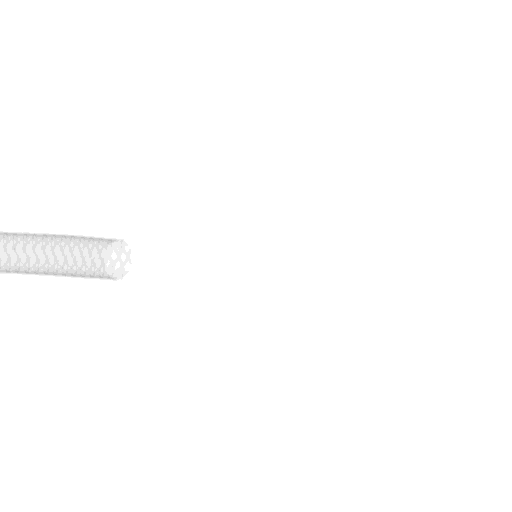

In [36]:
im = Image.open("dataset/base_png/base1.png")

# thumnail and refill

# im.thumbnail((500,500))
# im = ImageOps.expand(im, border=(20, 10), fill=pixel_max)

# rescale
a = 1
b = 0
c = im_size / 2.5  #left/right (i.e. 5/-5)
d = 0
e = 1
f = 0  #up/down (i.e. 5/-5)
# im = ImageTransform.AffineTransform(im, )
im.transform(im.size, Image.Transform.AFFINE, (a, b, c, d, e, f), fillcolor=pixel_max)

## Pipeline Creation
The following function combines multiple processing operations into one

In [39]:
def create_pipeline(*operations):
    """Select base image using selector function, and return the image after all transformations functions"""
    def pipeline(img: Image.Image):
        for op in operations:
            img = op(img)
        return img
    return pipeline

Function for selection of base image

In [41]:
def select() -> Image.Image:
    """Selects a random base image."""
    base_files = os.listdir(base_path)
    selected = rd.choice(base_files)
    return Image.open(os.path.join(base_path, selected))

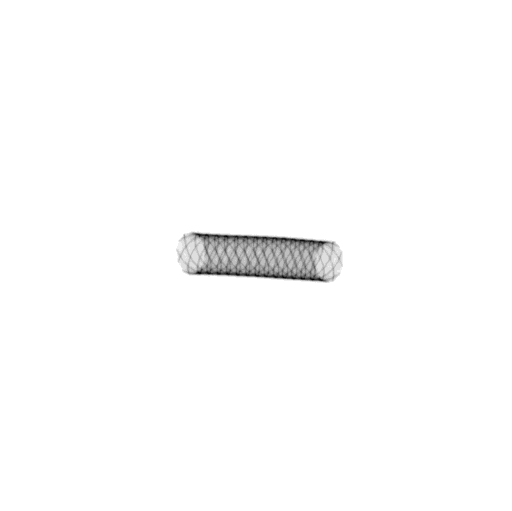

In [141]:
# example
test_img = select()
test_img

In [47]:
def rotate(img: Image.Image, angle=None) -> Image.Image:
    if angle is None:
        angle = rd.uniform(0, 360)
    return img.rotate(angle, fillcolor=pixel_max)

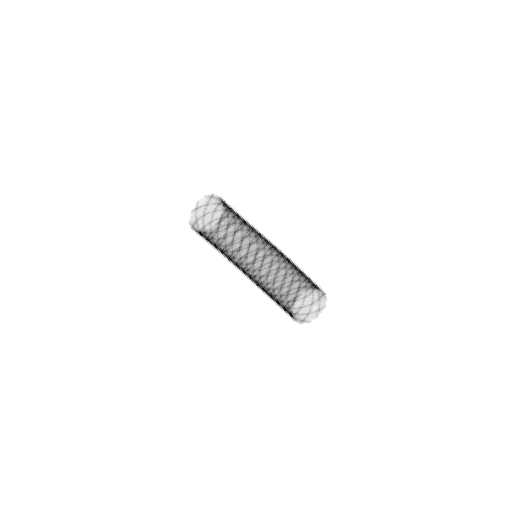

In [53]:
# example
test_img_rotated = rotate(test_img)
test_img_rotated

In [154]:
def rescale(img: Image.Image, scale=None) -> Image.Image:
    if not scale:
        scale = rd.uniform(0.2, 1.6)
    # shrink the image
    thumbnail_size = ceil(im_size * scale / 2) * 2

    # add border to have the original image dimensions if image is shrunken
    if thumbnail_size <= im_size:
        img.thumbnail((thumbnail_size, thumbnail_size))
        border_size = (im_size - thumbnail_size) // 2
        return ImageOps.expand(img, border=border_size, fill=pixel_max)

    # crop image if image is enlarged
    border_size = (thumbnail_size - im_size) // 2
    img = img.resize((thumbnail_size, thumbnail_size))
    return img.crop((border_size, border_size, border_size + im_size, border_size + im_size))

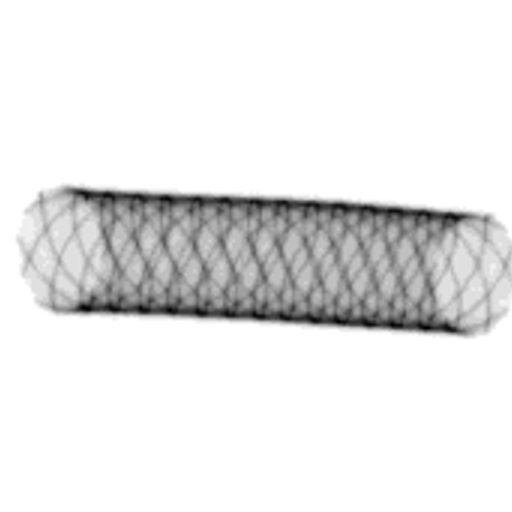

In [177]:
from copy import deepcopy
# example
test_img_rescaled = rescale(deepcopy(test_img), scale=3) # scale set to 3 only for visualization purposes
test_img_rescaled

In [83]:
def translate(img: Image.Image, tx=None, ty=None) -> Image.Image:
    """
    :param img: image file
    :param tx: the number of pixels the image is translated to the left
    :param ty: the number of pixels the image is translated to the right
    :return: the translated image
    """
    # if tx or ty set to none, randomly shift by -200 to 200 pixels in both directions
    if not tx:
        tx = rd.randint(-200, 200)
    if not ty:
        ty = rd.randint(-200, 200)
    return ImageChops.offset(img, tx, ty)

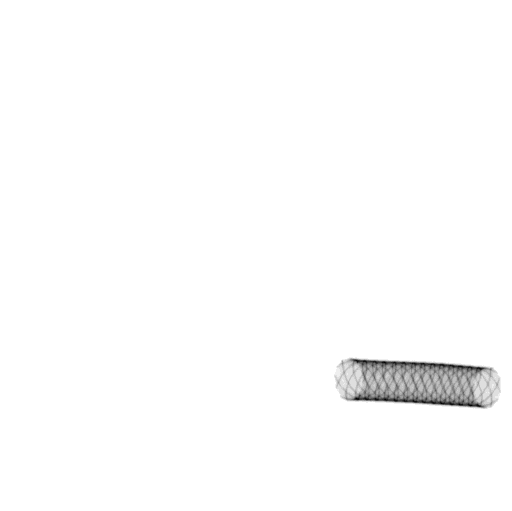

In [94]:
test_img_shifted = translate(test_img)
test_img_shifted

In [123]:
def flip_and_mirror(img: Image.Image) -> Image.Image:
    if np.random.uniform() >= 0.5: # flip with a probability of 0.5
        img = ImageOps.flip(img)
    if np.random.uniform() >= 0.5: # mirror with a probability of 0.5
        img = ImageOps.mirror(img)
    return img

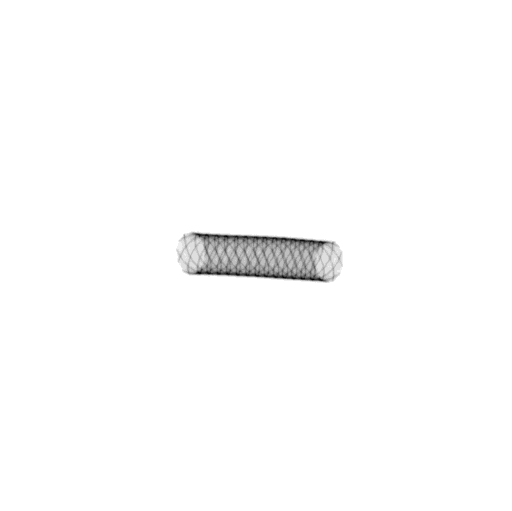

In [124]:
test_img_flipped_and_mirrored = flip_and_mirror(test_img)
test_img_flipped_and_mirrored

pipeline creation

In [178]:
pipeline = create_pipeline(flip_and_mirror, rotate, rescale, translate)

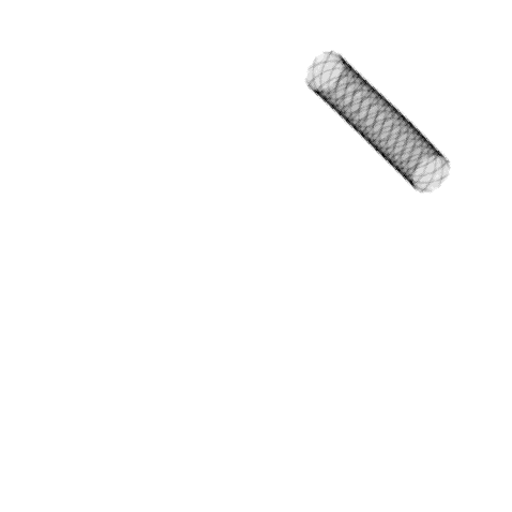

In [186]:
# test example
test_img_processed = pipeline(test_img)
test_img_processed

## Database creation

In [99]:
import uuid # for random image id generation

In [187]:
save_path = "dataset/train"

def generate_training_image(number):
    """Randomly generate a certain number of training images without noise"""
    if os.path.isdir(save_path): return # return if training image folder already exists
    os.makedirs(os.path.join(save_path, "x"))
    for _ in range(number):
        image_id = str(uuid.uuid4())
        img = select()
        img_processed = pipeline(img)
        img_processed.save(os.path.join(save_path, f"{image_id}.png"))

In [188]:
# number of images without noise
train_size = 20

In [189]:
generate_training_image(train_size)